In [2]:
import boto3
import pandas as pd
from io import StringIO
import os

ModuleNotFoundError: No module named 'boto3'

First let's grab some timeseries data using the boto3 package in Python

In [2]:
# Get the global gid csv file
# Initialize boto3 client
s3_client = boto3.client('s3')

# Define the S3 bucket and file path
bucket_name = 'era5-for-wrf'
file_key = 'era5_global_gids.csv'

# Get the file object
s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the file content
file_content = s3_object['Body'].read().decode('utf-8')

# Use StringIO to convert the file content to a file-like object
csv_string_io = StringIO(file_content)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_string_io, index_col = 0)

# Display the DataFrame
print(df)

NoCredentialsError: Unable to locate credentials

In [2]:
# Now let's define a function to return the GID for a given latitude and longitude
def get_gid(lat, lon, gid_df):
    # Round to the nearest 0.25 degrees
    lat = round(lat*4)/4
    lon = round(lon*4)/4

    # Find entry in gid_df with those lat/lons
    gid = gid_df[(gid_df['lat'] == lat) & (gid_df['lon'] == lon)]['gid'].values[0]

    # Return result
    return str(gid).zfill(7)

In [7]:
# Let's test it out
lat = 52.52
lon = 13.405
gid = get_gid(lat, lon, df)
print(f"The GID for latitude {lat} and longitude {lon} is {gid}")

NameError: name 'df' is not defined

In [6]:
# Now let's use the GID to download our data
# Define the S3 bucket and file path
bucket_name = 'era5-for-wrf'
file_key = f'global_single_level/cells/{gid}/timeseries.csv'

# Get the file object
s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Read the file content
file_content = s3_object['Body'].read().decode('utf-8')

# Use StringIO to convert the file content to a file-like object
csv_string_io = StringIO(file_content)

# Read the CSV file into a Pandas DataFrame
era5_df = pd.read_csv(csv_string_io, index_col = 0, skiprows = 1, parse_dates = True)

NameError: name 'gid' is not defined

In [21]:
# Let's look at the data
era5_df

,100-m wind speed (m/s),100-m wind direction (degrees),2-m temperature (K),surface pressure (Pa)
datetime,,,,
2000-01-01 00:00:00,4.09,190.88,272.30,101777.43
2000-01-01 01:00:00,4.05,193.58,272.50,101801.09
2000-01-01 02:00:00,4.19,197.67,272.38,101809.48
2000-01-01 03:00:00,4.25,199.57,272.37,101785.27
2000-01-01 04:00:00,4.30,200.83,272.70,101759.05
...,...,...,...,...
2024-03-31 19:00:00,3.93,298.71,285.64,99383.31
2024-03-31 20:00:00,4.07,316.15,284.35,99398.93
2024-03-31 21:00:00,4.12,340.19,283.41,99366.82


Now if we wanted to avoid the boto3 route, we can simply download data using AWS CLI: 

In [23]:
cmd = f"aws s3 cp s3://era5-for-wrf/global_single_level/cells/{gid}/timeseries.csv ."

os.system(cmd)

0

# Plotting the downloaded model level data

In [8]:
import xarray as xr
ds_u = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_2_u.regn320uv.2021062118_2021062123.nc')
ds_v = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_3_v.regn320uv.2021062118_2021062123.nc')

In [10]:
ws = (ds_u.U**2 + ds_v.V**2)**0.5

In [12]:
ws.longitude

<xarray.DataArray 'longitude' (longitude: 1280)> Size: 10kB
array([0.000000e+00, 2.812500e-01, 5.625000e-01, ..., 3.591562e+02,
       3.594375e+02, 3.597188e+02])
Coordinates:
  * longitude  (longitude) float64 10kB 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
Attributes:
    long_name:      longitude
    standard_name:  longitude
    short_name:     lon
    units:          degrees_east

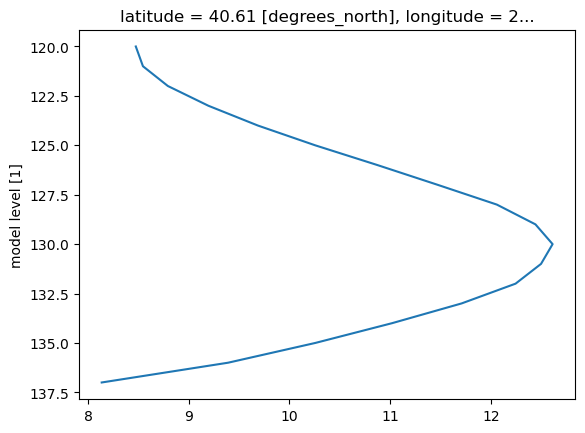

In [ ]:
import matplotlib.pyplot as plt
ws.sel(time='2021-06-21T21:00:00',level=slice(120,None)).sel(latitude=40.65025, longitude=-73.5054+360,method='nearest').plot(y='level')
# inverte the level axis
plt.gca().invert_yaxis()

In [22]:
import xarray as xr
ds_u = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_2_u.regn320uv.2001070518_2001070523.nc')
ds_v = xr.open_dataset('data/e5.oper.an.ml.0_5_0_2_3_v.regn320uv.2001070518_2001070523.nc')
ws = (ds_u.U**2 + ds_v.V**2)**0.5

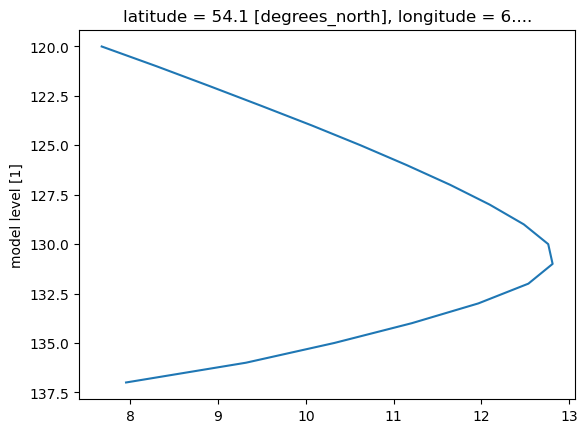

In [23]:
import matplotlib.pyplot as plt
ws.sel(time='2001-07-05T23:00:00',level=slice(120,None)).sel(latitude=54.0148618, longitude=6.5876398,method='nearest').plot(y='level')
# inverte the level axis
plt.gca().invert_yaxis()

In [9]:
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds

<xarray.Dataset> Size: 11PB
Dimensions:                              (time: 1323648, hybrid: 137,
                                          latitude: 721, longitude: 1440)
Coordinates:
  * hybrid                               (hybrid) float32 548B 1.0 2.0 ... 137.0
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 11MB 1900-01-0...
Data variables: (12/14)
    divergence                           (time, hybrid, latitude, longitude) float32 753TB ...
    fraction_of_cloud_cover              (time, hybrid, latitude, longitude) float32 753TB ...
    geopotential                         (time, hybrid, latitude, longitude) float32 753TB ...
    ozone_mass_mixing_ratio              (time, hybrid, latitude, longitude) float32 753TB ...
    specific_cloud_ice_water_content     (time, hybrid, latitude, longitude) float32 753TB ...
    specific_cloud_liquid_water_content  (time, hybrid, latitude, longitude) float32 753TB ...
    ...                                   ...
    specific_snow_water_content          (time, hybrid, latitude, longitude) float32 753TB ...
    temperature                          (time, hybrid, latitude, longitude) float32 753TB ...
    u_component_of_wind                  (time, hybrid, latitude, longitude) float32 753TB ...
    v_component_of_wind                  (time, hybrid, latitude, longitude) float32 753TB ...
    vertical_velocity                    (time, hybrid, latitude, longitude) float32 753TB ...
    vorticity                            (time, hybrid, latitude, longitude) float32 753TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-08-27 14:20:51.626245
    valid_time_stop:   2024-03-31

In [10]:
ds = ds[['u_component_of_wind', 'v_component_of_wind','geopotential']].sel(hybrid=slice(120,None),time=slice('2016-02-22T00','2016-02-22T12')).load()

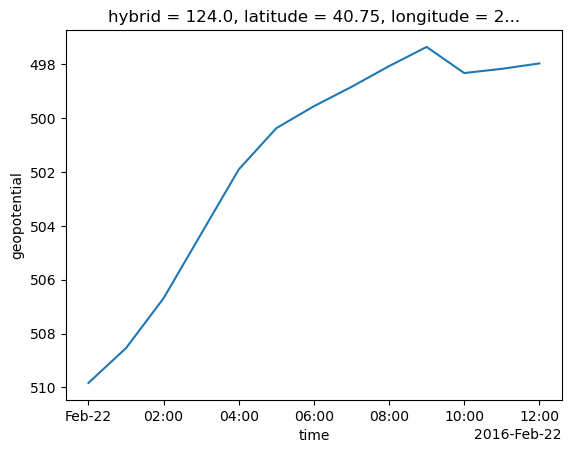

In [11]:
import matplotlib.pyplot as plt
z = ds.geopotential.sel(latitude=40.65025, longitude=-73.815856+360,method='nearest')/9.81
z.sel(hybrid=124).plot(x='time')
plt.gca().invert_yaxis()

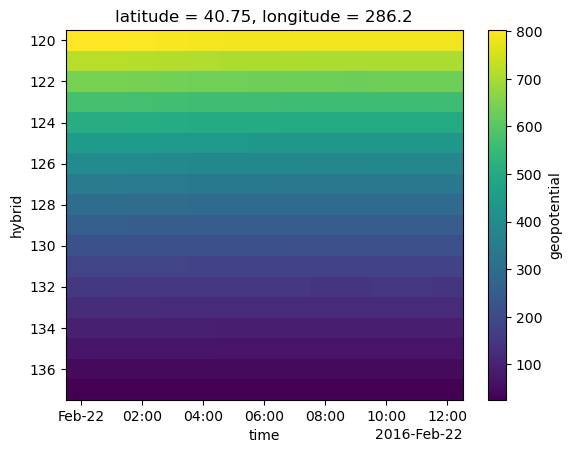

In [12]:
z.plot(x='time',y='hybrid')
plt.gca().invert_yaxis()

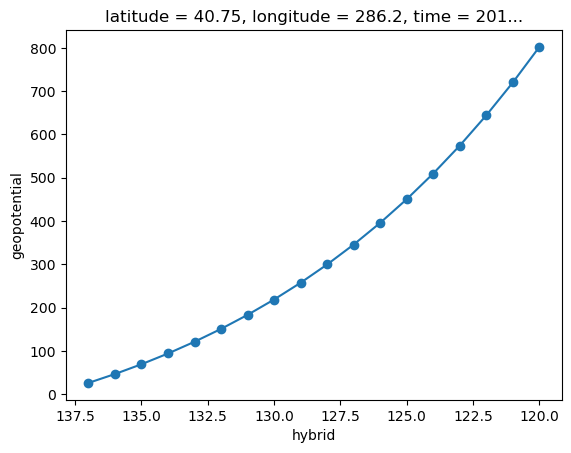

In [18]:
z.isel(time=0).plot(linestyle='-',marker='o')
plt.gca().invert_xaxis()

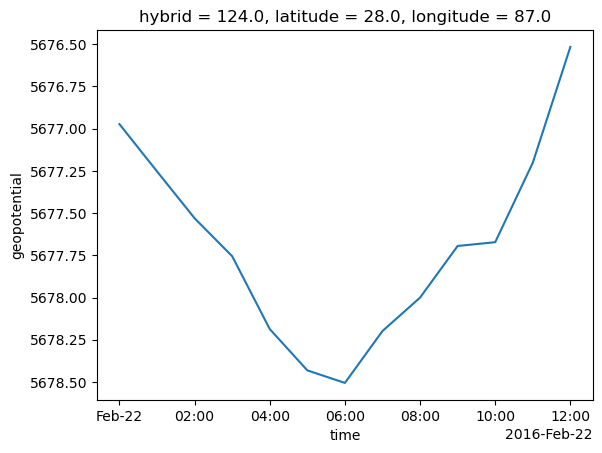

In [14]:
import matplotlib.pyplot as plt
z = ds.geopotential.sel(latitude=27.9881, longitude=86.9250,method='nearest')/9.773
z.sel(hybrid=124).plot(x='time')
plt.gca().invert_yaxis()

- Found a souce for the geometric height computation
- https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height

In [15]:
z

<xarray.DataArray 'geopotential' (time: 13, hybrid: 18)> Size: 936B
array([[5849.858 , 5802.2065, 5757.644 , 5715.973 , 5676.9736, 5640.4688,
        5606.271 , 5574.1934, 5544.0767, 5515.7344, 5489.0205, 5463.7515,
        5439.787 , 5416.9595, 5395.089 , 5374.0156, 5353.7393, 5334.9033],
       [5850.3086, 5802.605 , 5757.996 , 5716.285 , 5677.2534, 5640.719 ,
        5606.49  , 5574.3823, 5544.2383, 5515.872 , 5489.1416, 5463.8604,
        5439.8843, 5417.039 , 5395.148 , 5374.056 , 5353.771 , 5334.919 ],
       [5850.7446, 5802.996 , 5758.3477, 5716.599 , 5677.531 , 5640.968 ,
        5606.7173, 5574.586 , 5544.4155, 5516.0254, 5489.2725, 5463.973 ,
        5439.982 , 5417.1367, 5395.253 , 5374.162 , 5353.87  , 5334.9653],
       [5851.0044, 5803.261 , 5758.603 , 5716.8364, 5677.7554, 5641.1885,
        5606.944 , 5574.823 , 5544.665 , 5516.283 , 5489.5366, 5464.239 ,
        5440.2446, 5417.3853, 5395.4844, 5374.3784, 5354.0586, 5335.0493],
       [5851.563 , 5803.7773, 5759.0835, 5717.29  , 5678.1865, 5641.597 ,
        5607.3286, 5575.1914, 5545.026 , 5516.6416, 5489.8926, 5464.592 ,
        5440.595 , 5417.734 , 5395.8193, 5374.6777, 5354.297 , 5335.151 ],
       [5851.6753, 5803.9243, 5759.2656, 5717.5063, 5678.431 , 5641.8633,
        5607.6123, 5575.49  , 5545.3345, 5516.9565, 5490.21  , 5464.9097,
        5440.91  , 5418.0347, 5396.099 , 5374.9287, 5354.495 , 5335.2324],
       [5851.5503, 5803.8633, 5759.2603, 5717.547 , 5678.5054, 5641.9624,
        5607.732 , 5575.6245, 5545.478 , 5517.105 , 5490.362 , 5465.0615,
        5441.0596, 5418.1763, 5396.2236, 5375.027 , 5354.5576, 5335.253 ],
       [5850.8296, 5803.2744, 5758.782 , 5717.1597, 5678.198 , 5641.729 ,
        5607.5596, 5575.5024, 5545.4004, 5517.0645, 5490.3496, 5465.0693,
        5441.0776, 5418.1978, 5396.245 , 5375.0444, 5354.569 , 5335.257 ],
       [5850.345 , 5802.875 , 5758.4575, 5716.902 , 5678.0005, 5641.5815,
        5607.4517, 5575.423 , 5545.339 , 5517.014 , 5490.3066, 5465.033 ,
        5441.05  , 5418.178 , 5396.232 , 5375.037 , 5354.5635, 5335.2554],
       [5849.8916, 5802.459 , 5758.08  , 5716.562 , 5677.695 , 5641.308 ,
        5607.2134, 5575.222 , 5545.174 , 5516.881 , 5490.1997, 5464.9478,
        5440.9814, 5418.125 , 5396.193 , 5375.01  , 5354.548 , 5335.2495],
       [5849.957 , 5802.486 , 5758.0854, 5716.554 , 5677.6724, 5641.2666,
        5607.152 , 5575.1436, 5545.084 , 5516.784 , 5490.103 , 5464.8564,
        5440.897 , 5418.0493, 5396.126 , 5374.953 , 5354.505 , 5335.232 ],
       [5849.34  , 5801.905 , 5757.54  , 5716.045 , 5677.202 , 5640.8354,
        5606.7573, 5574.7817, 5544.7505, 5516.476 , 5489.8203, 5464.599 ,
        5440.6675, 5417.8506, 5395.963 , 5374.8276, 5354.422 , 5335.201 ],
       [5848.6567, 5801.207 , 5756.834 , 5715.3413, 5676.5166, 5640.184 ,
        5606.1553, 5574.2363, 5544.261 , 5516.0405, 5489.4326, 5464.253 ,
        5440.361 , 5417.584 , 5395.7383, 5374.6504, 5354.2964, 5335.153 ]],
      dtype=float32)
Coordinates:
  * hybrid     (hybrid) float32 72B 120.0 121.0 122.0 ... 135.0 136.0 137.0
    latitude   float32 4B 28.0
    longitude  float32 4B 87.0
  * time       (time) datetime64[ns] 104B 2016-02-22 ... 2016-02-22T12:00:00

In [16]:
Re  = 6371.2229*1000   # Earth radius in meters
Re*z/(Re-z)

<xarray.DataArray 'geopotential' (time: 13, hybrid: 18)> Size: 936B
array([[5855.234 , 5807.4956, 5762.852 , 5721.106 , 5682.0366, 5645.467 ,
        5611.209 , 5579.074 , 5548.9053, 5520.513 , 5493.754 , 5468.441 ,
        5444.4355, 5421.5693, 5399.661 , 5378.5522, 5358.2417, 5339.3745],
       [5855.6855, 5807.894 , 5763.2046, 5721.4185, 5682.317 , 5645.7173,
        5611.428 , 5579.264 , 5549.0674, 5520.652 , 5493.8745, 5468.5503,
        5444.533 , 5421.6484, 5399.72  , 5378.593 , 5358.274 , 5339.3896],
       [5856.122 , 5808.2866, 5763.5566, 5721.7324, 5682.5947, 5645.967 ,
        5611.6553, 5579.468 , 5549.2446, 5520.805 , 5494.0063, 5468.663 ,
        5444.6304, 5421.746 , 5399.826 , 5378.699 , 5358.373 , 5339.4365],
       [5856.3823, 5808.5522, 5763.8125, 5721.971 , 5682.82  , 5646.1875,
        5611.8823, 5579.706 , 5549.494 , 5521.0635, 5494.27  , 5468.9287,
        5444.8936, 5421.9956, 5400.0576, 5378.916 , 5358.5615, 5339.5205],
       [5856.942 , 5809.0693, 5764.294 , 5722.4253, 5683.2515, 5646.597 ,
        5612.268 , 5580.0737, 5549.8564, 5521.4224, 5494.627 , 5469.282 ,
        5445.2446, 5422.344 , 5400.3936, 5379.2153, 5358.8003, 5339.622 ],
       [5857.0547, 5809.216 , 5764.4766, 5722.642 , 5683.4966, 5646.8643,
        5612.552 , 5580.3735, 5550.1655, 5521.738 , 5494.945 , 5469.6016,
        5445.5605, 5422.646 , 5400.6733, 5379.4673, 5358.999 , 5339.7036],
       [5856.929 , 5809.156 , 5764.4717, 5722.6826, 5683.5713, 5646.963 ,
        5612.672 , 5580.508 , 5550.309 , 5521.886 , 5495.097 , 5469.7534,
        5445.7104, 5422.7876, 5400.798 , 5379.5654, 5359.0615, 5339.7246],
       [5856.2075, 5808.5654, 5763.992 , 5722.294 , 5683.263 , 5646.729 ,
        5612.499 , 5580.3857, 5550.2314, 5521.8457, 5495.085 , 5469.7607,
        5445.7285, 5422.8096, 5400.8193, 5379.583 , 5359.0728, 5339.7285],
       [5855.722 , 5808.165 , 5763.667 , 5722.036 , 5683.065 , 5646.581 ,
        5612.391 , 5580.306 , 5550.1694, 5521.7954, 5495.042 , 5469.725 ,
        5445.7   , 5422.7896, 5400.8057, 5379.5757, 5359.0674, 5339.727 ],
       [5855.2676, 5807.748 , 5763.2886, 5721.696 , 5682.759 , 5646.3076,
        5612.1523, 5580.105 , 5550.0044, 5521.6626, 5494.9346, 5469.639 ,
        5445.632 , 5422.737 , 5400.767 , 5379.5483, 5359.052 , 5339.7207],
       [5855.333 , 5807.7754, 5763.294 , 5721.688 , 5682.7363, 5646.2666,
        5612.091 , 5580.0264, 5549.914 , 5521.5654, 5494.8384, 5469.548 ,
        5445.5474, 5422.6606, 5400.7   , 5379.4917, 5359.009 , 5339.703 ],
       [5854.715 , 5807.193 , 5762.7476, 5721.1777, 5682.265 , 5645.8345,
        5611.696 , 5579.664 , 5549.58  , 5521.2563, 5494.555 , 5469.29  ,
        5445.3174, 5422.462 , 5400.5366, 5379.3657, 5358.926 , 5339.6724],
       [5854.031 , 5806.494 , 5762.0405, 5720.473 , 5681.5786, 5645.1816,
        5611.093 , 5579.1177, 5549.0903, 5520.8203, 5494.1665, 5468.9434,
        5445.0107, 5422.1943, 5400.312 , 5379.188 , 5358.8003, 5339.624 ]],
      dtype=float32)
Coordinates:
  * hybrid     (hybrid) float32 72B 120.0 121.0 122.0 ... 135.0 136.0 137.0
    latitude   float32 4B 28.0
    longitude  float32 4B 87.0
  * time       (time) datetime64[ns] 104B 2016-02-22 ... 2016-02-22T12:00:00

In [4]:
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/model-level-1h-0p25deg.zarr-v1',
    chunks=None,
    storage_options=dict(token='anon'),
)

ds = ds[['u_component_of_wind', 'v_component_of_wind','geopotential']].sel(hybrid=slice(120,None),time=slice('2016-02-22T00','2016-02-22T12')).load()

import metpy.calc
from metpy.units import units
geopot = ds.geopotential.isel(time=0).sel(latitude=27.9881, longitude=86.9250,method='nearest')
height = metpy.calc.geopotential_to_height(geopot)
print(height.values)


[5835.125  5787.5503 5743.06   5701.4575 5662.5225 5626.0786 5591.938
 5559.9146 5529.849  5501.5547 5474.8867 5449.6606 5425.739  5402.95
 5381.118  5360.0815 5339.8413 5321.038 ]


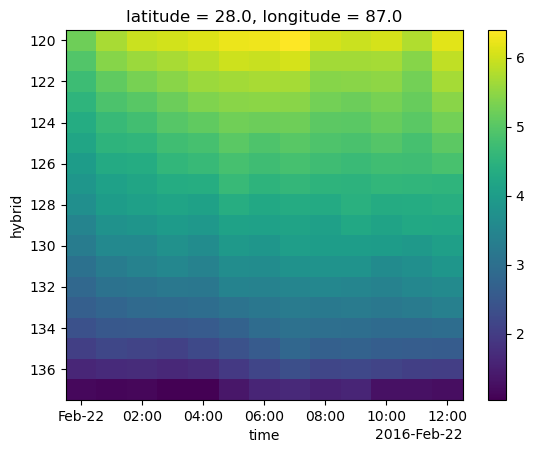

In [8]:
import matplotlib.pyplot as plt
ws = (ds.u_component_of_wind**2 + ds.v_component_of_wind**2)**0.5
ws = ws.sel(latitude=27.9881, longitude=86.9250,method='nearest')
ws.plot(x='time',y='hybrid')
plt.gca().invert_yaxis()

In [3]:
import xarray as xr
xr.open_dataset('data/output/data_1.nc', engine='netcdf4')

<xarray.Dataset> Size: 516MB
Dimensions:      (valid_time: 13, model_level: 18, values: 542080)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 104B 2016-02-21 ... 2016-02-21T1...
  * model_level  (model_level) float64 144B 120.0 121.0 122.0 ... 136.0 137.0
    latitude     (values) float64 4MB ...
    longitude    (values) float64 4MB ...
    expver       (valid_time) <U4 208B ...
Dimensions without coordinates: values
Data variables:
    q            (valid_time, model_level, values) float32 507MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts